In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.signal as signal
import lib.io.stan
import numpy as np
from matplotlib.lines import Line2D
import os

In [3]:
np.random.seed(0)
ntwrk = np.load('datasets/id002_cj/CJ_network.npz')
SC = ntwrk['SC']
K = np.max(SC)
SC = SC / K
SC[np.diag_indices(SC.shape[0])] = 0
gain = ntwrk['gain_mat']
sim_data_6d = np.load('datasets/id002_cj/CJ_syn_tvb_ez=6-34_pz=27-5-11.npz')

nn = SC.shape[0]
ns  = gain.shape[0]
nt = 75
I1 = 3.1
tau0 = 50.0
x0 = sim_data_6d['x0']
time_scale = 1.0
time_step = 0.5
nsteps = 1 #int(1/time_step)
sigma = 0.0
# k = 1.0
# epsilon = 0.01
x_init = -2.0*np.ones(nn)
z_init = 3.0*np.ones(nn)
z_eta = np.random.normal(size = (nt, nn))

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'SC':SC, 'gain':gain,
        'x0':x0, 'time_scale':time_scale, 'time_step':time_step, 'nsteps': nsteps,
        'sigma':sigma, 'K':K, 'x_init':x_init, 'z_init':z_init, 'z_eta':z_eta}
results_dir = 'results/exp10/exp10.20'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)
os.makedirs(f'{results_dir}/figures', exist_ok=True)
os.makedirs(f'{results_dir}/logs', exist_ok=True)
lib.io.stan.rdump(f'{results_dir}/Rfiles/sim_data.R',data)

In [4]:
%%bash -s "$results_dir"

RESULTS_DIR=$1
stancompile.sh vep-forwardsim-2Depileptor

./vep-forwardsim-2Depileptor sample num_warmup=0 num_samples=1 \
algorithm=fixed_param data file=${RESULTS_DIR}/Rfiles/sim_data.R output file=${RESULTS_DIR}/sim_out.csv

/home/anirudh/Academia/projects/vep.stan
make: '/home/anirudh/Academia/projects/vep.stan/vep-forwardsim-2Depileptor' is up to date.
method = sample (Default)
  sample
    num_samples = 1
    num_warmup = 0
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      delta = 0.80000000000000004 (Default)
      kappa = 0.75 (Default)
      t0 = 10 (Default)
      init_buffer = 75 (Default)
      term_buffer = 50 (Default)
      window = 25 (Default)
    algorithm = fixed_param
id = 0 (Default)
data
  file = results/exp10/exp10.20/Rfiles/sim_data.R
init = 2 (Default)
random
  seed = 2789155026
output
  file = results/exp10/exp10.20/sim_out.csv
  diagnostic_file =  (Default)
  refresh = 100 (Default)

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.022189 seconds (Sampling)
               0.022189 seconds (Total)



In [5]:
sim_out = lib.io.stan.read_samples([f'{results_dir}/sim_out.csv'])
ez = sim_data_6d['ez']
pz= np.concatenate((sim_data_6d['pz_x0'], sim_data_6d['pz_kplng']))
fit_data = np.load('datasets/id002_cj/CJ_fit_trgt.npz')

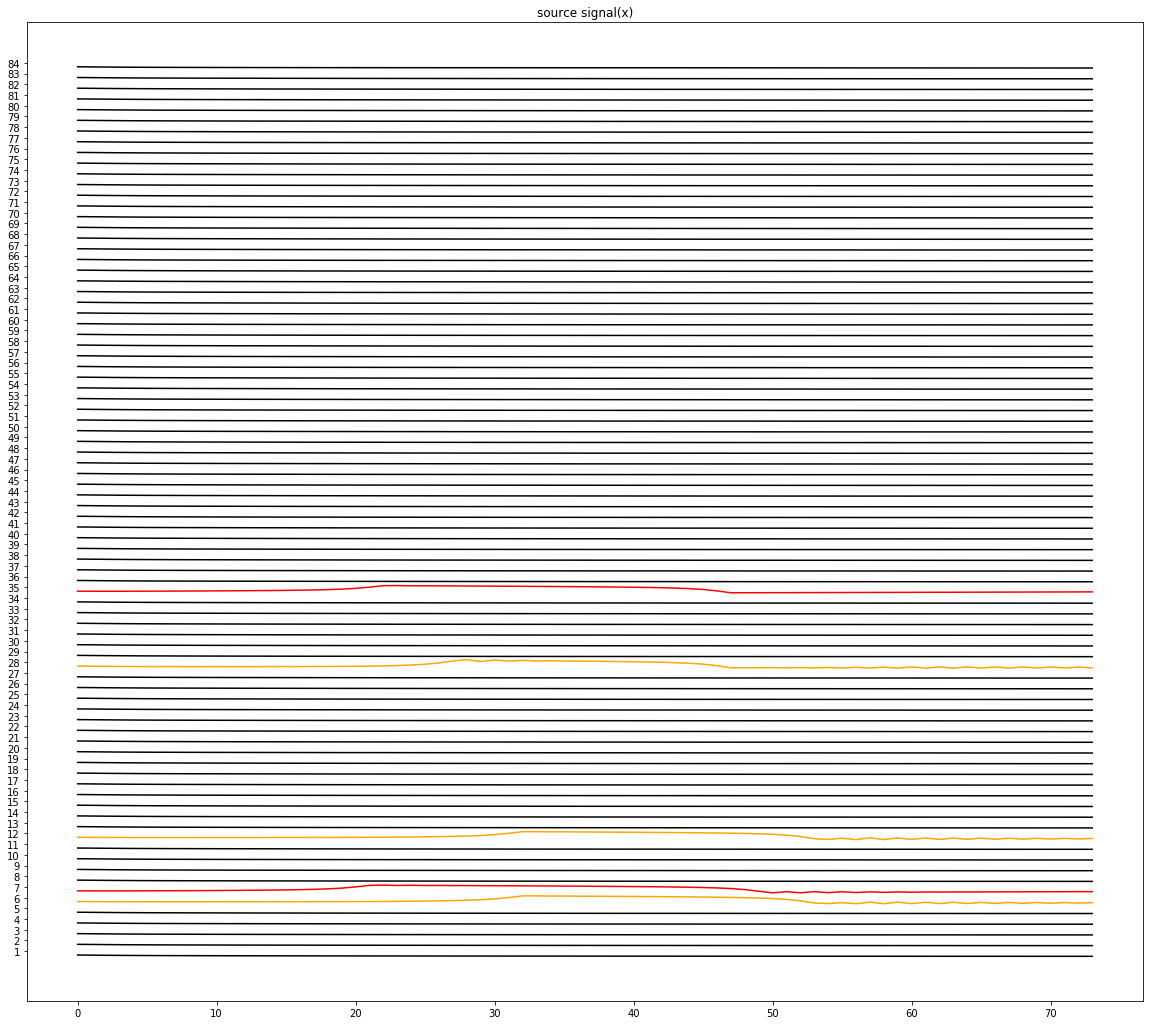

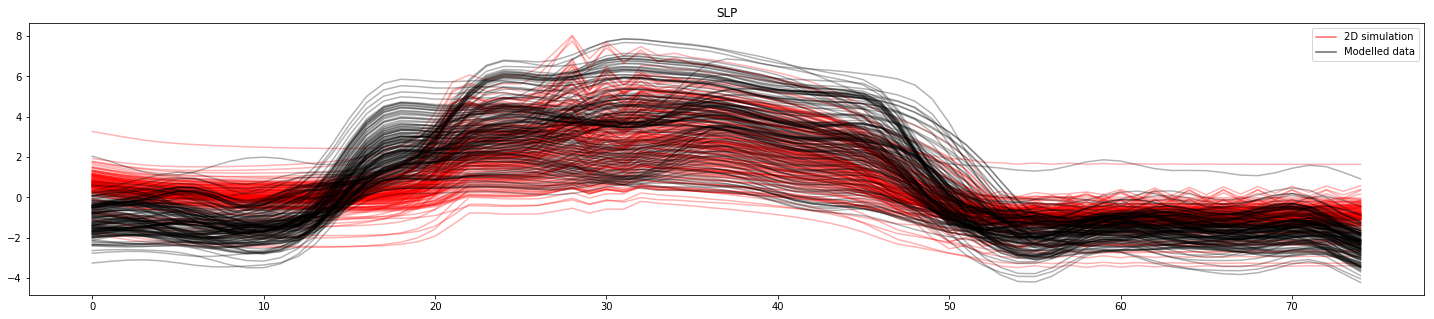

In [7]:
start_idx = 0 #4950
end_idx = -1 #start_idx + 1500

plt.figure(figsize=(20,18))
# plt.plot(sim_out['x'][0,start_idx:end_idx,:]/4.0 + np.r_[0:nn],'k');
# plt.yticks(np.r_[1:nn], np.r_[1:nn])
for i in range(nn):
    if(i in ez):
#         plt.plot(sim_out['x'][0,:,i], color='red')
        plt.plot(sim_out['x'][0,start_idx:end_idx,i]/4.0 + i, color='red');
    elif(i in pz):
#         plt.plot(sim_out['x'][0,:,i], color='orange')
        plt.plot(sim_out['x'][0,start_idx:end_idx,i]/4.0 + i, color='orange');
    else:
#         plt.plot(sim_out['x'][0,:,i], color='black')
        plt.plot(sim_out['x'][0,start_idx:end_idx,i]/4.0 + i, color='black');
plt.title('source signal(x)')
plt.yticks(np.r_[0:nn],np.r_[1:nn+1])
plt.savefig(f'{results_dir}/figures/simulated_source_at_ground_truth')

# plt.figure(figsize=(25,5))
# plt.plot(sim_out['seeg'][0,start_idx:end_idx,:],alpha=0.3);
# plt.title('SEEG')

amplitude = 3.5
offset = -3.0
plt.figure(figsize=(25,5))
plt.plot(amplitude*(sim_out['slp'][0,...] + offset), alpha=0.3, color='red');
plt.plot(fit_data['fit_trgt'][0:-1:20,:], alpha=0.3, color='black');
plt.title('SLP')
legend_elements = [Line2D([0],[0], color='red', alpha=0.6, label='2D simulation'),
                   Line2D([0],[0], color='black', alpha=0.6, label='Modelled data')]
plt.legend(handles=legend_elements)
plt.savefig(f'{results_dir}/figures/simulated_seeg_at_ground_truth')